# CNN demo

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

Requires Keras to be installed:

```
pip install tensorflow
pip install keras
```

In [56]:
#= run once
using Conda
Conda.add("pillow")
Conda.add("tensorflow")
Conda.add("keras")
=#
using PyCall,PyPlot
KerasPreprocessing = pyimport("keras.preprocessing")
plt = pyimport("matplotlib.pyplot")
KerasResNet50 = pyimport("keras.applications.resnet50")
os = pyimport("os")
using Printf
KerasDatasets = pyimport("keras.datasets")
KerasUtils = pyimport("keras.utils")
KerasModels = pyimport("keras.models")
KerasLayersCore = pyimport("keras.layers.core")
KerasLayersConvolutional = pyimport("keras.layers.convolutional")

PyObject <module 'keras.layers.convolutional' from 'C:\\Users\\jasonsyc.STUDENTS.000\\.julia\\conda\\3\\lib\\site-packages\\keras\\layers\\convolutional.py'>

Load a **pre-trained** 50-layer "residual network" trained on the ImageNet dataset.

In [2]:
model = KerasResNet50.ResNet50(weights="imagenet")

Instructions for updating:
Colocations handled automatically by placer.


2019-08-03 02:12:44.191403: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX
2019-08-03 02:12:44.192914: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


PyObject <keras.engine.training.Model object at 0x000000003EE53080>

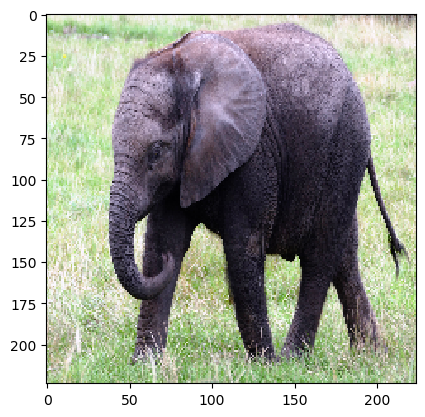

In [31]:
function prep_show_img(img_path)
    img = KerasPreprocessing.image.load_img(os.path.join("img", img_path), target_size=(224, 224))
    plt.imshow(img);
    return img
end
img = prep_show_img("elephant.jpg");

In [29]:
function predict(model, img)
    x = KerasPreprocessing.image.img_to_array(img)
    x=reshape(x,1, size(x)[1], size(x)[2], size(x)[3])
    x = KerasResNet50.preprocess_input(x)

    preds = model.predict(x)
    return KerasResNet50.decode_predictions(preds, top=3)
end

println(predict(model, img))

Tuple{String,String,Float64}[("n02504458", "African_elephant", 0.713196) ("n01871265", "tusker", 0.177048) ("n02504013", "Indian_elephant", 0.108073)]


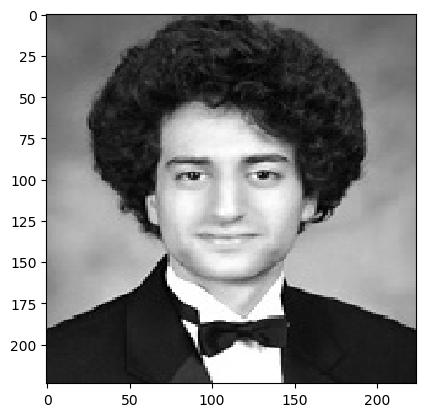

In [32]:
img = prep_show_img("gelbart-michael-adam.jpg");

In [34]:
println(predict(model, img));

Tuple{String,String,Float64}[("n02883205", "bow_tie", 0.987281) ("n03838899", "oboe", 0.00472647) ("n03110669", "cornet", 0.00173041)]


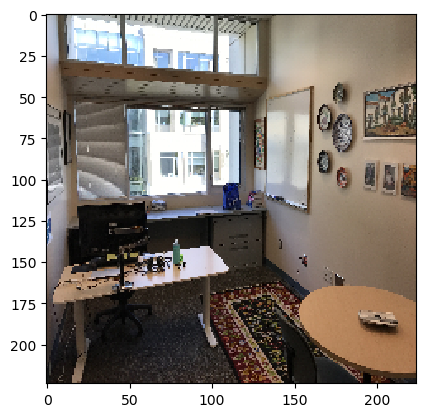

In [36]:
img = prep_show_img("office.jpg");

In [38]:
println(predict(model, img))

Tuple{String,String,Float64}[("n04005630", "prison", 0.294901) ("n03179701", "desk", 0.0659852) ("n04239074", "sliding_door", 0.0461867)]


## Computation

Some nice things deep learning software can do for you:

- automatic differentiation
- compile/optimize code, especially for GPU 
- numerically stable implementations
- implementation of various regularizers (like dropout) and solvers (like Adam)
- a common standard for a community of users

## GPUs

- A big part of the deep learning revolution
- GPUs were originally designed for graphics --> _matrix multiplication_
  - This is what we need for neural networks
- Leader is NVIDIA, their GPU programming language is called CUDA.
  - These days we can usually avoid writing in CUDA
  - NVIDIA's share price 2 years ago: \$35. Now: \$220.
  
From Jeff Bezos' 2017 letter to shareholders:

> Using our pre-packaged versions of popular deep learning frameworks running on P2 compute instances (optimized for this workload), customers are already developing powerful systems ranging everywhere from early disease detection to increasing crop yields. [...] Watch this space. Much more to come.

- More recently: [P3 instances](https://aws.amazon.com/ec2/instance-types/p3/).

![](img/nvidia_ticker.png)

## Cloud computing

- CUDA-capable NVIDIA GPUs are [expensive](https://www.amazon.com/Nvidia-Tesla-GDDR5-Cores-Graphic/dp/B00Q7O7PQA). 
- Cloud computing platforms enable easy (and sometimes free) access. 
  - Big players are AWS EC2, Google Cloud, Microsoft Azure

## Demos

The data is built in to Keras, so we just access it for convenience. If not present already it is automatically downloaded.

Attribution: the code below is adapted from the [Keras MNIST example](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py), which is under the [MIT license](https://github.com/fchollet/keras/blob/master/LICENSE).

In [45]:
# the data, shuffled and split between train and test sets
(X_train, y_train_cat), (X_test, y_test_cat) = KerasDatasets.mnist.load_data()

img_dim = (28,28) 
img_size = img_dim[1]*img_dim[2]
num_classes = 10

X_train = convert(Array{Float32},X_train)
X_test  = convert(Array{Float32},X_test)
X_train ./= 255
X_test  ./= 255
X_train_flat = reshape(X_train, 60000, img_size)
X_test_flat  = reshape(X_test, 10000, img_size)
X_train = reshape(X_train, size(X_train)[1], size(X_train)[2], size(X_train)[3], 1) # add 4th dimension, needed later for convnets
X_test  = reshape(X_test, size(X_test)[1], size(X_test)[2], size(X_test)[3], 1)

# convert class vectors to binary class matrices
y_train = KerasUtils.to_categorical(y_train_cat, num_classes)
y_test = KerasUtils.to_categorical(y_test_cat, num_classes)

println(size(X_train)[1], " train samples")
print(size(X_test)[1], " test samples")

60000 train samples
10000 test samples

## Demo 1: scikit-learn

In [47]:
SkNeuralNetwork = pyimport("sklearn.neural_network") #import MLPClassifier

PyObject <module 'sklearn.neural_network' from 'C:\\Users\\jasonsyc.STUDENTS.000\\.julia\\conda\\3\\lib\\site-packages\\sklearn\\neural_network\\__init__.py'>

In [50]:
@time begin

    nn = SkNeuralNetwork.MLPClassifier(hidden_layer_sizes=(100,100), max_iter=10, 
                       batch_size=128)
    nn.fit(X_train_flat, y_train_cat)

    score = nn.score(X_train_flat, y_train_cat)
    println("Train accuracy: ", score)

    score = nn.score(X_test_flat, y_test_cat)
    println("Test accuracy: ", score)

end

Train accuracy: 0.9967


C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Test accuracy: 0.9784
 35.894149 seconds (562 allocations: 29.469 KiB)


## Demo 2: Keras

### Fully-connected net

** Model definition **

Here we need to specify the input and output size in advance (unlike sklearn) because the model is first _compiled_.

In [53]:
model = KerasModels.Sequential()
model.add(KerasLayersCore.Dense(100, input_shape=(size(X_train_flat)[2],), activation="relu"))
model.add(KerasLayersCore.Dense(100, activation="relu"))
model.add(KerasLayersCore.Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

** Training and evaluation **

In [55]:
@time begin

    history = model.fit(X_train_flat, y_train,
                        batch_size=128, 
                        epochs=10,
                        verbose=0)

    score = model.evaluate(X_train_flat, y_train, verbose=0)
    println("Train accuracy: ", score[2])

    score = model.evaluate(X_test_flat, y_test, verbose=0)
    println("Test accuracy: ", score[1])

end

Instructions for updating:
Use tf.cast instead.
Train accuracy: 0.9923833333333333
Test accuracy: 0.09494330027866527
 47.633125 seconds (347.06 k allocations: 17.843 MiB, 0.01% gc time)


### Convolutional net

Attribution: the code below is adapted from [Deep Learning with Python](https://machinelearningmastery.com/deep-learning-with-python2/) with permission from the author.

** Model definition **

In [63]:
model = KerasModels.Sequential()
model.add(KerasLayersConvolutional.Convolution2D(32, (5, 5), input_shape=(img_dim[1],img_dim[2],1), activation="relu"))
model.add(KerasLayersConvolutional.MaxPooling2D(pool_size=(2, 2)))
model.add(KerasLayersCore.Dropout(0.2))
model.add(KerasLayersCore.Flatten())
model.add(KerasLayersCore.Dense(128, activation="relu"))
model.add(KerasLayersCore.Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


** Training and evaluation **

In [65]:
@time begin

    history = model.fit(X_train, y_train,
                        batch_size=128, 
                        epochs=1,
                        verbose=0)

    score = model.evaluate(X_train, y_train, verbose=0)
    println("Train accuracy: ", score[2])

    score = model.evaluate(X_test, y_test, verbose=0)
    println("Test accuracy: ", score[2])
    
end

Train accuracy: 0.9805
Test accuracy: 0.979
154.827451 seconds (96.30 k allocations: 4.933 MiB)


## Demo 3: Training in the cloud

Instructions:

- Go to https://colab.research.google.com/
- Make an account
- Upload notebook or create a new one
- Runtime --> change runtime type
- Select GPU

Typical speedups of **10x**. This translates into more prototyping, more optimization, better models.

## Model architecture and number of parameters

In [70]:
# define a simple CNN model
model = KerasModels.Sequential()
model.add(KerasLayersConvolutional.Conv2D(32, (5, 5), input_shape=(28, 28, 3), activation="relu"))
model.add(KerasLayersConvolutional.MaxPooling2D(pool_size=(2, 2)))
model.add(KerasLayersCore.Dropout(0.2))
model.add(KerasLayersConvolutional.Conv2D(32, (5, 5), activation="relu"))
model.add(KerasLayersConvolutional.MaxPooling2D(pool_size=(2, 2)))
model.add(KerasLayersCore.Dropout(0.2))
model.add(KerasLayersCore.Flatten())
model.add(KerasLayersCore.Dense(10, activation="softmax"))

Can we account for all these parameters?

- The 1st convolutional layer has $5\times 5\times 3\times 32$ (+32 bias).
  - this results in images of size 24x24 (we're throwing away the boundaries) 
  - after 2x2 max pooling they are 12x12. 
- The 2nd convolutional layer has $5\times 5\times 32\times 32$ (+32 bias). 
  - this results in images of size 8x8 
  - after 2x2 max pooling they are 4x4. 
  - after flattening we have $4\times 4 \times 32 = 512$ units
- The fully connected layer has $512 \times 10$ (+10 bias).

Total numer of parameters: 

In [66]:
(5*5*3*32 + 32) + (5*5*32*32 + 32) + (512*10 + 10)

33194

We can confirm below:

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
__________

If you understand the above calculation, you understand CNNs to a level _beyond_ what you need for CPSC 340. 

We'll actually train such a model next class. It's too slow on my laptop!